## 1. Анализ структуры данных и предобработка
1.1 Исследование структуры данных

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from math import sqrt
from scipy.stats import t

# Чтение данных
data = pd.read_csv('ab_data_tourist.csv')

# Изучаем структуру данных
data.info()

# Просмотр первых 5 строк
data.head()

# Проверим дубликаты по user_id и другим параметрам
print("Количество полных дубликатов строк:", data.duplicated().sum())

# Количество уникальных пользователей
print("Количество уникальных пользователей:", data['user_id'].nunique())

# Проверим распределение по группам
print(data['group'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
Количество полных дубликатов строк: 74
Количество уникальных пользователей: 290584
B    147276
A    147202
Name: group, dtype: int64


1. У нас есть большой набор данных с почти 300 тысяч строк и 5 столбцами.

2. В наборе есть 74 полных дубликата, которые нужно удалить.

3. Даты записаны в текстовом формате, и их нужно преобразовать в правильный формат для работы с ними.

4. Столбцы с покупками и ценами уже имеют правильный числовой формат.

5. В данных зарегистрировано 290 584 уникальных пользователя, что говорит о том, что некоторые из них встречаются несколько раз.

6. Пользователи равномерно распределены между двумя группами (A и B): в группе B чуть больше записей, чем в A, но разница незначительная.

1.2 Преобразование столбцов к необходимым типам данных

In [3]:
# Преобразуем столбец date к формату datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Проверим, что преобразование прошло успешно
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


1.3 Проверка одинаковой длительности проведения A/B-тестирования

In [4]:
# Определим период тестирования для каждой группы
min_date_A = data.loc[data['group'] == 'A', 'date'].min()
max_date_A = data.loc[data['group'] == 'A', 'date'].max()

min_date_B = data.loc[data['group'] == 'B', 'date'].min()
max_date_B = data.loc[data['group'] == 'B', 'date'].max()

print("Группа A: c", min_date_A, "по", max_date_A)
print("Группа B: c", min_date_B, "по", max_date_B)

# Находим пересекающийся диапазон дат
start_date = max(min_date_A, min_date_B)
end_date = min(max_date_A, max_date_B)

print("Пересекающийся период:", start_date, "по", end_date)

# Отфильтруем данные, оставив только пересекающийся период
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Повторная проверка
min_date_A = data.loc[data['group'] == 'A', 'date'].min()
max_date_A = data.loc[data['group'] == 'A', 'date'].max()

min_date_B = data.loc[data['group'] == 'B', 'date'].min()
max_date_B = data.loc[data['group'] == 'B', 'date'].max()

print("После унификации периодов:")
print("Группа A: c", min_date_A, "по", max_date_A)
print("Группа B: c", min_date_B, "по", max_date_B)


Группа A: c 2021-01-02 00:00:00 по 2021-01-24 00:00:00
Группа B: c 2021-01-02 00:00:00 по 2021-01-24 00:00:00
Пересекающийся период: 2021-01-02 00:00:00 по 2021-01-24 00:00:00
После унификации периодов:
Группа A: c 2021-01-02 00:00:00 по 2021-01-24 00:00:00
Группа B: c 2021-01-02 00:00:00 по 2021-01-24 00:00:00


1.4 Удаление пропусков

In [5]:
# Проверка на пропуски
print(data.isna().sum())


user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64


In [6]:
# Проверим количество полных дубликатов
print("Количество полных дубликатов строк:", data.duplicated().sum())

# Удалим дубликаты
data = data.drop_duplicates()

# Проверим ещё раз
print("Количество полных дубликатов строк после удаления:", data.duplicated().sum())


Количество полных дубликатов строк: 74
Количество полных дубликатов строк после удаления: 0


1.5 Проверка на пользователей в обеих группах

In [7]:
# Определим для каждого пользователя количество уникальных групп, в которых он участвовал
user_groups = data.groupby('user_id')['group'].nunique()

# Выберем пользователей, которые оказались сразу в двух группах
users_in_both_groups = user_groups[user_groups > 1].index

print("Число пользователей в обеих группах:", len(users_in_both_groups))

# Если такие пользователи есть, исключим их из датафрейма
if len(users_in_both_groups) > 0:
    data = data[~data['user_id'].isin(users_in_both_groups)]

# Проверим, что теперь в данных не осталось пользователей из обеих групп
user_groups_after = data.groupby('user_id')['group'].nunique()
print("Число пользователей в обеих группах после фильтрации:", (user_groups_after > 1).sum())


Число пользователей в обеих группах: 1895
Число пользователей в обеих группах после фильтрации: 0


## 2 Первичный анализ результатов A/B-теста 

2.1 Рассчёт вспомогательных показателей для контрольной и тестовой групп

In [8]:
# Группируем данные по группе и рассчитываем необходимые показатели
summary = data.groupby('group').agg({
    'user_id': 'count',    # количество посещений сайта (каждая строка = визит)
    'purchase': 'sum',     # суммарное количество покупок 
    'price': 'sum'         # сумма всех покупок
}).rename(columns={'user_id': 'visits', 'purchase': 'total_purchases', 'price': 'total_revenue'})

summary


,visits,total_purchases,total_revenue
group,,,
A,145268,17487,1417780000
B,145346,17290,1533010000


разница всего в 78 визитов на ~145 тысяч, то есть менее 0,1%. Можно говорить о том, что выборки по количеству визитов сбалансированы.

По числу совершённых покупок результаты также близки.

Суммарная выручка в группе B несколько выше, несмотря на то, что количество покупок в обеих группах практически одинаково.

Можно корректно сравнивать метрики конверсии и среднего чека между группами

2.2 Рассчет ключевых показателей

In [9]:
# Извлечём необходимые показатели из предыдущей таблицы (summary)
visits_A = summary.loc['A', 'visits']
visits_B = summary.loc['B', 'visits']

total_purchases_A = summary.loc['A', 'total_purchases']
total_purchases_B = summary.loc['B', 'total_purchases']

total_revenue_A = summary.loc['A', 'total_revenue']
total_revenue_B = summary.loc['B', 'total_revenue']

# Конверсия
conversion_A = total_purchases_A / visits_A
conversion_B = total_purchases_B / visits_B

# Средний чек
avg_check_A = total_revenue_A / total_purchases_A
avg_check_B = total_revenue_B / total_purchases_B

conversion_A, conversion_B, avg_check_A, avg_check_B

(0.12037750915549192,
 0.11895752205083043,
 81076.22805512666,
 88664.54598033546)

Конверсия:

Вариант A: примерно 12,04%
Вариант B: примерно 11,90%
По конверсии вариант A немного превосходит вариант B.

Средний чек:

Вариант A: около 81 076 руб.
Вариант B: около 88 665 руб.
По среднему чеку вариант B значительно превосходит вариант A.



Общий промежуточный вывод:
На первый взгляд, у варианта A выше конверсия, то есть большее число пользователей, зашедших на страницу, совершают покупку. Однако у варианта B средний чек заметно выше, что в случае равных или близких по величине конверсий может привести к большей выручке. Вариант A лучше по показателю конверсии, вариант B лучше по показателю среднего чека.

2.3 Сравнение вариантов A/B по турпродуктам

In [11]:
# Создадим сводную таблицу по совершённым покупкам
pivot_tours = data[data['purchase'] == 1].pivot_table(
    index='group', 
    columns='price', 
    values='user_id', 
    aggfunc='count',
    fill_value=0
)

pivot_tours


price,10000,60000,100000,150000,200000
group,,,,,
A,5253,5343,1859,3527,1741
B,5257,1748,5311,3481,1717


<Figure size 1000x600 with 0 Axes>

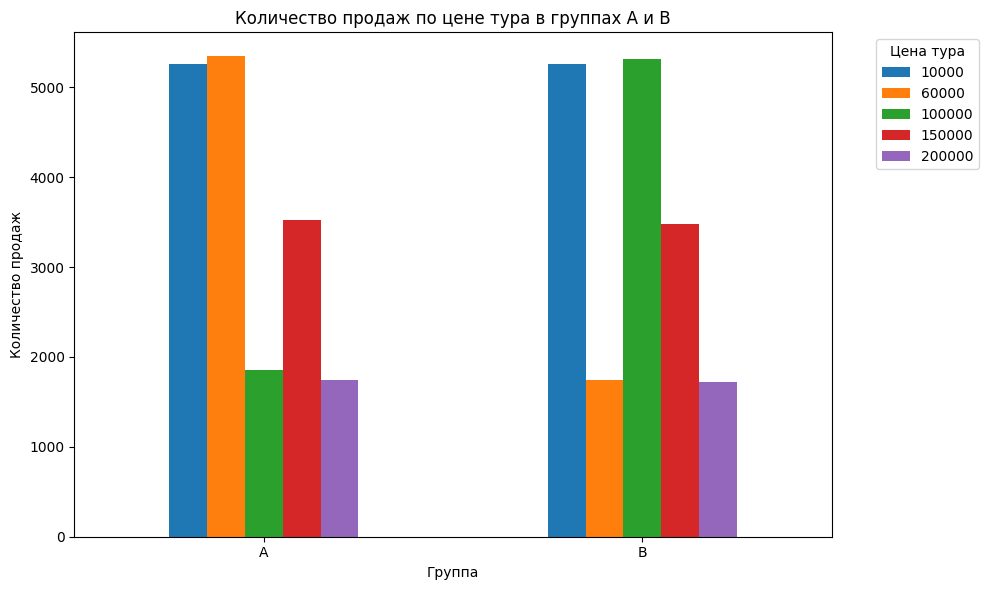

In [12]:
plt.figure(figsize=(10, 6))
pivot_tours.plot(kind='bar', stacked=False, figsize=(10,6))
plt.title("Количество продаж по цене тура в группах A и B")
plt.xlabel("Группа")
plt.ylabel("Количество продаж")
plt.xticks(rotation=0)
plt.legend(title="Цена тура", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


1. Дешёвые туры (10 000 руб.):

   • Продажи почти одинаковые в обеих группах: 5253 у группы A и 5257 у группы B. Это значит, что обе группы заинтересованы в покупке самых дешёвых туров.

2. Туры средней стоимости (60 000 руб.):

   • Группа A значительно опережает группу B: 5343 покупки против 1748. Участники группы A гораздо активнее покупают туры за 60 тысяч рублей.

3. Туры по средней-высокой цене (100 000 руб.):

   • Здесь группа B лидирует: 5311 покупок против 1859 у группы A. Люди из группы B чаще выбирают туры за 100 тысяч рублей.

4. Туры высокой стоимости (150 000 руб.):

   • Группа A немного лучше, чем группа B: 3527 против 3481. Разница небольшая, но группа A чуть больше склонна к покупке дорогих туров.

5. Самые дорогие туры (200 000 руб.):

   • Группа A также немного опережает группу B: 1741 против 1717. Разница минимальна, но всё же в пользу группы A.

▎Общий итог:

• Группа A лучше продаёт туры за 60 000 рублей и немного больше покупает дорогие туры (150 000 и 200 000 рублей).

• Группа B значительно лучше продаёт туры за 100 000 рублей.

• В продажах самых дешёвых туров (10 000 рублей) разницы почти нет.

Таким образом, можно сказать, что группа A более склонна покупать туры за 60 000, 150 000 и 200 000 рублей, а группа B — за 100 000 рублей.

## 3 Анализ данных на предмет стабилизации метрик

3.1 Формирование таблицы ежедневных данных

In [13]:
daily_data = (
    data
    .groupby(['date', 'group'])
    .agg(
        daily_visits=('user_id', 'count'),
        daily_purchases=('purchase', 'sum'),
        daily_revenue=('price', 'sum')
    )
    .reset_index()
)

daily_data.head()


,date,group,daily_visits,daily_purchases,daily_revenue
0,2021-01-02,A,2894,362,29720000
1,2021-01-02,B,2889,348,29920000
2,2021-01-03,A,6684,760,62640000
3,2021-01-03,B,6710,762,66540000
4,2021-01-04,A,6655,810,64970000


3.2 Вычисление ежедневных конверсии и среднего чека

In [14]:
daily_data['daily_conversion'] = daily_data['daily_purchases'] / daily_data['daily_visits']

# При вычислении среднего чека стоит учесть, что если purchases=0, то деление приведёт к ошибке.
# Предположим, что в каждый день были хотя бы какие-то покупки. Если нет — нужно это обработать.
daily_data['daily_avg_check'] = daily_data.apply(
    lambda row: row['daily_revenue'] / row['daily_purchases'] if row['daily_purchases'] > 0 else 0,
    axis=1
)

daily_data.head()


,date,group,daily_visits,daily_purchases,daily_revenue,daily_conversion,daily_avg_check
0,2021-01-02,A,2894,362,29720000,0.125086,82099.447514
1,2021-01-02,B,2889,348,29920000,0.120457,85977.011494
2,2021-01-03,A,6684,760,62640000,0.113704,82421.052632
3,2021-01-03,B,6710,762,66540000,0.113562,87322.834646
4,2021-01-04,A,6655,810,64970000,0.121713,80209.876543


3.3 Расчёт кумулятивных показателей

In [15]:
# Отсортируем данные по группе и дате для корректного вычисления кумулятивных сумм
daily_data = daily_data.sort_values(by=['group', 'date'])

# Рассчитаем кумулятивные показатели внутри каждой группы
daily_data['cum_visits'] = daily_data.groupby('group')['daily_visits'].cumsum()
daily_data['cum_purchases'] = daily_data.groupby('group')['daily_purchases'].cumsum()
daily_data['cum_revenue'] = daily_data.groupby('group')['daily_revenue'].cumsum()

daily_data.head()


,date,group,daily_visits,daily_purchases,daily_revenue,daily_conversion,daily_avg_check,cum_visits,cum_purchases,cum_revenue
0,2021-01-02,A,2894,362,29720000,0.125086,82099.447514,2894,362,29720000
2,2021-01-03,A,6684,760,62640000,0.113704,82421.052632,9578,1122,92360000
4,2021-01-04,A,6655,810,64970000,0.121713,80209.876543,16233,1932,157330000
6,2021-01-05,A,6538,801,65710000,0.122515,82034.956305,22771,2733,223040000
8,2021-01-06,A,6684,778,64440000,0.116397,82827.763496,29455,3511,287480000


3.4 Расчёт кумулятивных метрик

In [16]:
daily_data['cum_conversion'] = daily_data['cum_purchases'] / daily_data['cum_visits']

# Для вычисления среднего чека убедимся, что cum_purchases не ноль
daily_data['cum_avg_check'] = daily_data.apply(
    lambda row: row['cum_revenue'] / row['cum_purchases'] if row['cum_purchases'] > 0 else 0,
    axis=1
)

daily_data.head()


,date,group,daily_visits,daily_purchases,daily_revenue,daily_conversion,daily_avg_check,cum_visits,cum_purchases,cum_revenue,cum_conversion,cum_avg_check
0,2021-01-02,A,2894,362,29720000,0.125086,82099.447514,2894,362,29720000,0.125086,82099.447514
2,2021-01-03,A,6684,760,62640000,0.113704,82421.052632,9578,1122,92360000,0.117143,82317.290553
4,2021-01-04,A,6655,810,64970000,0.121713,80209.876543,16233,1932,157330000,0.119017,81433.747412
6,2021-01-05,A,6538,801,65710000,0.122515,82034.956305,22771,2733,223040000,0.120021,81609.952433
8,2021-01-06,A,6684,778,64440000,0.116397,82827.763496,29455,3511,287480000,0.119199,81879.806323


3.5 Построение кумулятивных графиков

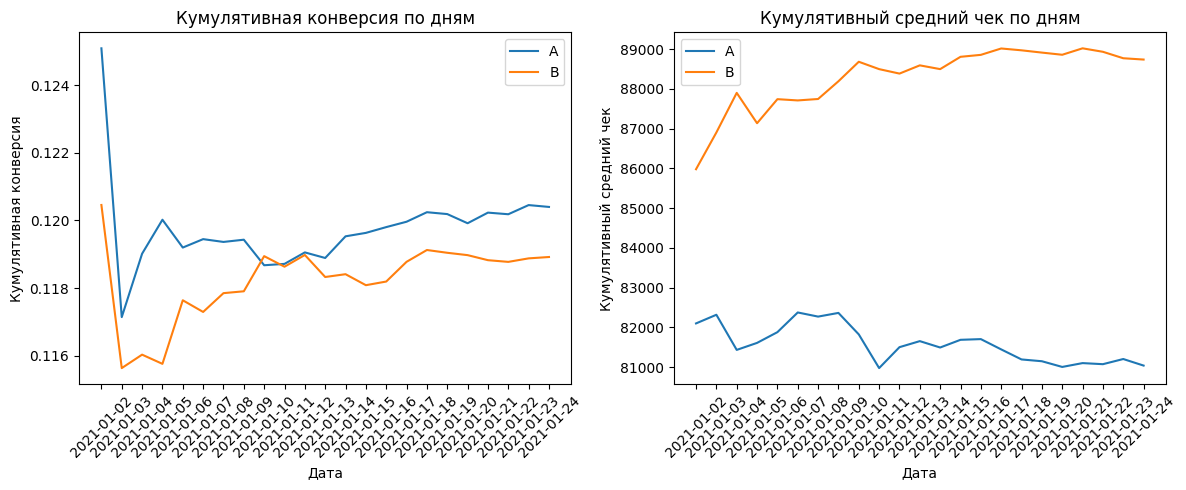

In [17]:
# Фильтруем данные по группам
daily_a = daily_data[daily_data['group'] == 'A']
daily_b = daily_data[daily_data['group'] == 'B']

plt.figure(figsize=(12, 5))

# Кумулятивная конверсия
plt.subplot(1, 2, 1)
sns.lineplot(data=daily_a, x='date', y='cum_conversion', label='A')
sns.lineplot(data=daily_b, x='date', y='cum_conversion', label='B')
plt.title('Кумулятивная конверсия по дням')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.xticks(rotation=45)

# Кумулятивный средний чек
plt.subplot(1, 2, 2)
sns.lineplot(data=daily_a, x='date', y='cum_avg_check', label='A')
sns.lineplot(data=daily_b, x='date', y='cum_avg_check', label='B')
plt.title('Кумулятивный средний чек по дням')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


1. Кумулятивная конверсия:

   • На графике видно, что группа A показывает более высокую конверсию, чем группа B. К концу теста колебания в показателях уменьшились, что говорит о том, что конверсия в группе A стабильно выше.

2. Кумулятивный средний чек:

   • Средний чек в группе B постепенно увеличивался и к концу теста стал значительно выше, чем в группе A. Показатели также стали более стабильными, что указывает на то, что группа B достигла хорошего уровня.

3. Завершение теста:

   • В конце теста метрики обеих групп стабилизировались: конверсия в группе A выше, а средний чек в группе B выше. Когда показатели перестают сильно меняться, это означает, что тест длился достаточно долго для принятия решения.

▎Общие соотношения:

• Группа A показывает лучшую конверсию.

• Группа B имеет более высокий средний чек.

В итоге, тест можно считать завершённым, так как метрики достигли стабильного уровня, и теперь можно переходить к статистическому анализу для окончательного решения.

## 4 статистический анализ результатов A/B-тестирования


4.1 Формулировка статистических гипотез и выбор теста Для проведения статистического анализа

1. Различается ли конверсия между группами A и B?

   • Конверсия — это процент пользователей, которые сделали покупку после посещения сайта. Мы хотим узнать, в какой группе конверсия выше.

   • Нулевая гипотеза (H0): Конверсия в группе A равна конверсии в группе B.

   • Альтернативная гипотеза (H1): Конверсия в группе A не равна конверсии в группе B.

   • Для проверки будем использовать z-тест для сравнения долей, так как конверсия — это процент (покупка сделана или нет).

2. Различается ли средний чек между группами A и B?

   • Средний чек — это средняя сумма, которую тратят пользователи при покупке. Перед тем как выбрать тест, нужно проверить, нормально ли распределены данные о среднем чеке.

   • Проверку нормальности можно сделать с помощью специальных тестов (например, тест Шапиро-Уилка) или просто визуально оценив графики. Если данных много, то согласно центральной предельной теореме, средний чек можно считать нормально распределённым.

   • Нулевая гипотеза (H0): Средний чек в группе A равен среднему чеку в группе B.

   • Альтернативная гипотеза (H1): Средний чек в группе A не равен среднему чеку в группе B.

   • Выбор теста для среднего чека:

     • Если данные нормально распределены и имеют схожую вариативность, используем t-тест для независимых выборок.

     • Если распределение сильно отличается от нормального или есть выбросы, используем непараметрический тест Манна-Уитни.

▎Резюме по выбору тестов:

• Для конверсии: используем z-тест для сравнения долей.

• Для среднего чека: сначала проверяем нормальность.

  • Если нормальность есть — используем t-тест.

  • Если нормальности нет — используем тест Манна-Уитни.

4.2  Проверка разницы между конверсиями в группах A и B

In [18]:
# Числа успехов (покупок) и общих наблюдений (визитов) для групп A и B
purchases_A = summary.loc['A', 'total_purchases']
visits_A = summary.loc['A', 'visits']

purchases_B = summary.loc['B', 'total_purchases']
visits_B = summary.loc['B', 'visits']

count = np.array([purchases_A, purchases_B])
nobs = np.array([visits_A, visits_B])

# Z-тест для пропорций
stat, p_value = proportions_ztest(count, nobs)
print("Проверка разницы конверсий A vs B:")
print("Z-статистика:", stat)
print("p-значение:", p_value)


Проверка разницы конверсий A vs B:
Z-статистика: 1.1792379652289662
p-значение: 0.23830343241067387


In [19]:
# Выберем ежедневный средний чек для групп A и B
daily_avg_A = daily_data.loc[daily_data['group'] == 'A', 'daily_avg_check']
daily_avg_B = daily_data.loc[daily_data['group'] == 'B', 'daily_avg_check']

# Проверим нормальность распределения среднего чека в группах
_, p_A = shapiro(daily_avg_A)
_, p_B = shapiro(daily_avg_B)
print("Проверка нормальности для A:", p_A)
print("Проверка нормальности для B:", p_B)


Проверка нормальности для A: 0.28827998303909397
Проверка нормальности для B: 0.13828545599460867


Интерпретация результатов по конверсии:

Z-статистика: 1.1792379652289662
p-значение: ~0.2383
При уровне значимости 5% (альфа = 0.05) p-значение больше 0.05, следовательно, мы не можем отвергнуть нулевую гипотезу о равенстве конверсий в группах A и B. Другими словами, статистически значимых отличий в конверсии между группами не выявлено.

Проверка нормальности для среднего чека:

Для группы A: p-значение теста Шапиро-Уилка ~0.2883
Для группы B: p-значение теста Шапиро-Уилка ~0.1383
Оба p-значения больше 0.05, значит мы не отвергаем гипотезу о нормальности распределения среднего чека для обоих выборок. Поскольку данные не противоречат предположению о нормальности, мы можем использовать параметрический тест (t-тест) для проверки различий в средних чеках.

In [22]:
# Выборки ежедневного среднего чека для групп A и B 
daily_avg_A = daily_data.loc[daily_data['group'] == 'A', 'daily_avg_check']
daily_avg_B = daily_data.loc[daily_data['group'] == 'B', 'daily_avg_check']

# Проведём t-тест (Welch’s t-test)
stat_check, p_check = ttest_ind(daily_avg_A, daily_avg_B, equal_var=False)
print("Результаты t-теста для среднего чека:")
print("T-статистика:", stat_check)
print("p-значение:", p_check)


Результаты t-теста для среднего чека:
T-статистика: -9.761734301683154
p-значение: 4.634490597191615e-12


При уровне значимости 5% (альфа = 0.05) такое маленькое p-значение говорит о том, что мы отвергаем нулевую гипотезу о равенстве средних чеков. Это означает, что средние чеки в группах A и B статистически значимо различаются.

Итог по статистическим тестам:

Конверсия: статистически значимых различий не обнаружено (p-value > 0.05).
Средний чек: статистически значимые различия есть (p-value < 0.05)

4.3 Доверительные интервалы для конверсий

In [24]:
# Данные для конверсии
p_A = purchases_A / visits_A
p_B = purchases_B / visits_B

z = 1.96  # 95%-ый доверительный интервал для нормального распределения

# ДИ для конверсии A
conf_A_lower = p_A - z * sqrt(p_A*(1-p_A)/visits_A)
conf_A_upper = p_A + z * sqrt(p_A*(1-p_A)/visits_A)

# ДИ для конверсии B
conf_B_lower = p_B - z * sqrt(p_B*(1-p_B)/visits_B)
conf_B_upper = p_B + z * sqrt(p_B*(1-p_B)/visits_B)

print("95% ДИ для конверсии A: [{:.4f}, {:.4f}]".format(conf_A_lower, conf_A_upper))
print("95% ДИ для конверсии B: [{:.4f}, {:.4f}]".format(conf_B_lower, conf_B_upper))

95% ДИ для конверсии A: [0.1187, 0.1221]
95% ДИ для конверсии B: [0.1173, 0.1206]


In [25]:
diff = p_A - p_B
se_diff = sqrt(p_A*(1-p_A)/visits_A + p_B*(1-p_B)/visits_B)

conf_diff_lower = diff - z * se_diff
conf_diff_upper = diff + z * se_diff

print("95% ДИ для разницы конверсий (A - B): [{:.4f}, {:.4f}]".format(conf_diff_lower, conf_diff_upper))


95% ДИ для разницы конверсий (A - B): [-0.0009, 0.0038]


In [26]:
mean_A = daily_avg_A.mean()
mean_B = daily_avg_B.mean()

std_A = daily_avg_A.std(ddof=1)
std_B = daily_avg_B.std(ddof=1)

n_A_days = len(daily_avg_A)
n_B_days = len(daily_avg_B)

# Квантиль для t-распределения с (n-1) степенью свободы (приблизительно для обоих возьмём отдельно)
t_val_A = t.ppf(1-0.025, df=n_A_days-1)
t_val_B = t.ppf(1-0.025, df=n_B_days-1)

conf_A_lower_check = mean_A - t_val_A * std_A/sqrt(n_A_days)
conf_A_upper_check = mean_A + t_val_A * std_A/sqrt(n_A_days)

conf_B_lower_check = mean_B - t_val_B * std_B/sqrt(n_B_days)
conf_B_upper_check = mean_B + t_val_B * std_B/sqrt(n_B_days)

print("95% ДИ для среднего чека A: [{:.2f}, {:.2f}]".format(conf_A_lower_check, conf_A_upper_check))
print("95% ДИ для среднего чека B: [{:.2f}, {:.2f}]".format(conf_B_lower_check, conf_B_upper_check))


95% ДИ для среднего чека A: [79588.22, 82274.37]
95% ДИ для среднего чека B: [87702.41, 89576.18]


4.4 Интерпретация доверительных интервалов:

Интерпретация доверительных интервалов:

Конверсия:

Доверительный интервал для конверсии в группе A: [0.1187, 0.1221]
Доверительный интервал для конверсии в группе B: [0.1173, 0.1206]
Интервалы частично пересекаются. Более того, 95%-й доверительный интервал для разницы конверсий (A - B) равен [-0.0009, 0.0038]. Этот интервал включает в себя ноль, что означает, что с учётом статистической погрешности мы не можем уверенно заявить о превосходстве одной группы над другой по конверсии.

Проще говоря, несмотря на то, что точечная оценка конверсии у группы A чуть выше, интервал разницы конверсий охватывает ноль, свидетельствуя о том, что статистически значимого различия не обнаружено.

Средний чек:

Доверительный интервал для среднего чека A: [79 588.22, 82 274.37]
Доверительный интервал для среднего чека B: [87 702.41, 89 576.18]
Доверительные интервалы для среднего чека в группах A и B не пересекаются. Это значит, что истинный средний чек в группе B статистически значимо выше, чем в группе A. Пересечение интервалов отсутствует, а значит, мы с высокой вероятностью можем утверждать о существенном различии в пользу группы B.

Вывод по перекрытию интервалов:

Для конверсий интервалы пересекаются, а разница охватывает нулевое значение. Это говорит о том, что при данном уровне достоверности нельзя с уверенностью утверждать о различиях конверсии между группами.
Для среднего чека интервалы не пересекаются. Это подтверждает статистически значимые различия в среднем чеке между группами, причём группа B демонстрирует существенно более высокий средний чек.

## 5 Общий вывод по результатам A/B-теста 

Конверсия:
Анализ показал, что конверсия в группе A была чуть выше по точечной оценке, но статистические тесты и доверительные интервалы не подтвердили наличие статистически значимых различий. Доверительный интервал разницы конверсий включает ноль, а p-значение z-теста больше 0.05. Это означает, что при данных условиях нельзя утверждать, что одна из групп принципиально лучше по этому показателю.

Средний чек:
По среднему чеку группа B значительно опередила группу A. Статистический t-тест выявил значимые различия (p-значение крайне мало, гораздо меньше 0.05), а доверительные интервалы для среднего чека в группах не пересекаются. Это говорит о том, что средний чек в группе B устойчиво выше, чем в группе A.

Ответ на бизнес-вопрос:

По показателю конверсии явного победителя нет — статистически значимых различий не обнаружено.
По среднему чеку вариант B значительно превосходит вариант A.
Исходя из этого, если цель компании — увеличить выручку и получать больше денег с каждой покупки, то более эффективным вариантом будет посадочная страница из группы B. Она приводит к более высокому среднему чеку, что может быть выгодно для компании.